# Question 1: Is "goodwill" mentioned more often in 10-K, 10-Q, or 8-K reports?

##Section I: Create an index of filings from SEC EDGAR

In [ ]:
#import all necessary packages 
import requests
import pandas as pd
import numpy as np
from io import StringIO
from bs4 import BeautifulSoup
from google.colab import output
import matplotlib.pyplot as plt

In [ ]:
'''
SUMMARY: 
  1. Code block to create a loop that combines the index files from 2017 through 2022. 
  2. Merge the combined index file with the list of S&P 500 firms given as part of Case 1
  3. Keep only cases that show up in both datasets (inner join)
  4. Finally, mask the resulting DataFrame to return only 10-K, 10-Q, and 8-K filings.
'''

#set an email and username to give SEC EDGAR for requests
dl_user_email = 'beraxax950@haizail.com' 
dl_user_name = 'No Company (personal research)' 

#instantiate the master data frame which will be populated with filings
master_df = pd.DataFrame()

#loop through the desired range of years
for yr in range(2000, 2020):
  #loop through each quarter of each year
  for qtr in range(1,5):    
     #create the url, adding in each year and quarter value
     url = f"https://www.sec.gov/Archives/edgar/full-index/{yr}/QTR{qtr}/company.idx"
     idx_content = requests.get(url, headers={'User-Agent': f'{dl_user_name} {dl_user_email}'}).content
     temp_df = pd.read_fwf(StringIO(idx_content.decode('ISO-8859-1')), skiprows=(0,1,2,3,4,5,6,7,9), widths = [62,12,12,12,52])
     #add two column to the dataframe, populating with the year and quarter (obtained from the current loop position)
     temp_df['YR'] = yr
     temp_df['QTR'] = qtr 
     #concatenate the master and temporary dataframes 
     master_df = pd.concat([master_df, temp_df])    

#EDGAR only includes the suffix of the URLs, so must add on the prefix to the master df to complete the URLs
master_df['File Name'] = 'https://www.sec.gov/Archives/' + master_df['File Name']

#merge on the given list of S&P 500 CIDS
sp500 = pd.read_csv('https://tinyurl.com/sp500ciks')
sp500_fs_data = pd.merge(left = sp500, 
                         right = master_df,  
                         left_on = 'cik',
                         right_on = 'CIK',
                         how = 'inner')

#mask the merged dataframe to only display 10-K, 10-Q, 8-K filings 
my_func_ret_df = sp500_fs_data.loc[(sp500_fs_data['Form Type'] == "10-K") | (sp500_fs_data['Form Type'] == "10-Q") | (sp500_fs_data['Form Type'] == "8-K"),:].copy()

#create separate dataframes for each of the key filing types, for future sampling
df_only_10_K = sp500_fs_data.loc[(sp500_fs_data['Form Type'] == "10-K"),:].copy()
df_only_10_Q = sp500_fs_data.loc[(sp500_fs_data['Form Type'] == "10-Q"),:].copy()
df_only_8_K = sp500_fs_data.loc[(sp500_fs_data['Form Type'] == "8-K"),:].copy()

In [ ]:
#create a copy of the index so that it is not necessary to run the code again
filing_index_backup = my_func_ret_df.copy()
#save a file backup too (same reasoning)
my_func_ret_df.to_csv("filing_index_backup")

##Section II: Define a context_search function

In [ ]:
'''
SUMMARY
  1. Define a modified context search function in order to search each filing in our dataframe. 
  2. Create a list (context_list) adding all the context relevant to each mention

'''

#write a modified version of the context search function to pull the context around a search term
def context_search(url, search_phrase, context_distance):
    search_start = 0
    context_list = []
    #request the content of the filing from EDGAR using the defined user name and email
    text = str(requests.get(url, headers={'User-Agent': f'{dl_user_name} {dl_user_email}'}).content).lower() 

    #for each instance of the defined search_phrase, return the text within context_distance and add it as an element to context_list
    for occurance in range(text.count(search_phrase)):
        location = text.find(search_phrase, search_start)
        context_string = text[location-context_distance:location+context_distance]
        search_start = location + 1
        context_list.append([context_string])
    
    #if context_list has any content, then return to context list. Otherwise return a null value
    if len(context_list) > 0:
        return context_list
    else:
        return np.nan

In [ ]:
df_only_10_K

,company name,cik,Company Name,Form Type,CIK,Date Filed,File Name,YR,QTR
77,ADC TELECOMMUNICATIONS INC,61478,ADC TELECOMMUNICATIONS INC,10-K,61478,2002-01-16,https://www.sec.gov/Archives/edgar/data/61478/...,2002,1
97,ADC TELECOMMUNICATIONS INC,61478,ADC TELECOMMUNICATIONS INC,10-K,61478,2003-01-10,https://www.sec.gov/Archives/edgar/data/61478/...,2003,1
159,ADC TELECOMMUNICATIONS INC,61478,ADC TELECOMMUNICATIONS INC,10-K,61478,2004-01-15,https://www.sec.gov/Archives/edgar/data/61478/...,2004,1
238,ADC TELECOMMUNICATIONS INC,61478,ADC TELECOMMUNICATIONS INC,10-K,61478,2005-01-14,https://www.sec.gov/Archives/edgar/data/61478/...,2005,1
320,ADC TELECOMMUNICATIONS INC,61478,ADC TELECOMMUNICATIONS INC,10-K,61478,2006-01-17,https://www.sec.gov/Archives/edgar/data/61478/...,2006,1
...,...,...,...,...,...,...,...,...,...
1606254,CERIDIAN HCM HOLDING,1725057,Ceridian HCM Holding Inc.,10-K,1725057,2019-02-28,https://www.sec.gov/Archives/edgar/data/172505...,2019,1
1606402,MODERNA INC,1682852,"Moderna, Inc.",10-K,1682852,2019-03-13,https://www.sec.gov/Archives/edgar/data/168285...,2019,1
1606660,BAKER HUGHES CO,1701605,Baker Hughes a GE Co,10-K,1701605,2018-02-23,https://www.sec.gov/Archives/edgar/data/170160...,2018,1
1606761,BAKER HUGHES CO,1701605,Baker Hughes a GE Co,10-K,1701605,2019-02-19,https://www.sec.gov/Archives/edgar/data/170160...,2019,1


## Section II: Run samples of 100 of each filing type, then apply context_search, and summarize the findings

In [ ]:
#draw a random sample of filings from the 10-K index
sample_10K = df_only_10_K.sample(100).reset_index(drop = True)


#loop over items in the DF and apply the function to each URL
for row in range(len(sample_10K)):
    sample_10K.loc[row,"gw_context"] = context_search(sample_10K.loc[row,'File Name'], "goodwill", 500)
   
    if type(sample_10K.loc[row,"gw_context"]) == list:
        sample_10K.loc[row,"gw_count"] = len(sample_10K.loc[row,"gw_context"])
    else:
        sample_10K.loc[row,"gw_count"] = 0

#aggregate mean, count, and sum to quickly assess the findings
sample_10K[['gw_count']].aggregate(["mean","count", "sum"])

,gw_count
mean,332.59
count,100.00
sum,33259.00


In [ ]:
#draw a random sample of filings from the 10-Q index
sample_10Q = df_only_10_Q.sample(100).reset_index(drop = True)


#loop over items in the DF and apply the function to each URL
for row in range(len(sample_10Q)):
    sample_10Q.loc[row,"gw_context"] = context_search(sample_10Q.loc[row,'File Name'], "goodwill", 500)
   
    if type(sample_10Q.loc[row,"gw_context"]) == list:
        sample_10Q.loc[row,"gw_count"] = len(sample_10Q.loc[row,"gw_context"])
    else:
        sample_10Q.loc[row,"gw_count"] = 0
        
#aggregate mean, count, and sum to quickly assess the findings
sample_10Q[['gw_count']].aggregate(["mean","count", "sum"])

,gw_count
mean,135.19
count,100.00
sum,13519.00


In [ ]:
#draw a random sample of filings from the 8-K index
sample_8K = df_only_8_K.sample(100).reset_index(drop = True)


#loop over items in the DF and apply the function to each URL
for row in range(len(sample_8K)):
    sample_8K.loc[row,"gw_context"] = context_search(sample_8K.loc[row,'File Name'], "goodwill", 500)
   
    if type(sample_8K.loc[row,"gw_context"]) == list:
        sample_8K.loc[row,"gw_count"] = len(sample_8K.loc[row,"gw_context"])
    else:
        sample_8K.loc[row,"gw_count"] = 0

#aggregate mean, count, and sum to quickly assess the findings
sample_8K[['gw_count']].aggregate(["mean","count", "sum"])

,gw_count
mean,0.7
count,100.0
sum,70.0


###Conclusion from Samples
Goodwill is most commonly mentioned in 10-Ks and 10-Qs. 
In order to efficiently use computer resource power and capture the important statistics only, 8-Ks should not be processed going forward. 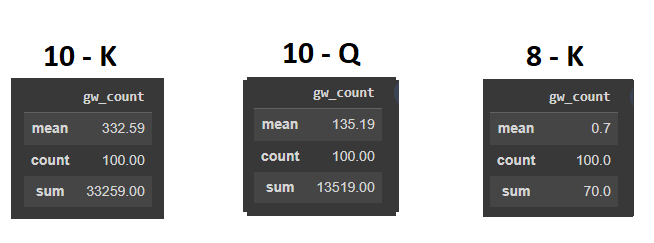


Note: sampling is inherently random, so re-running the notebook will yield different results than those presented above. 

##Section III: Visualization

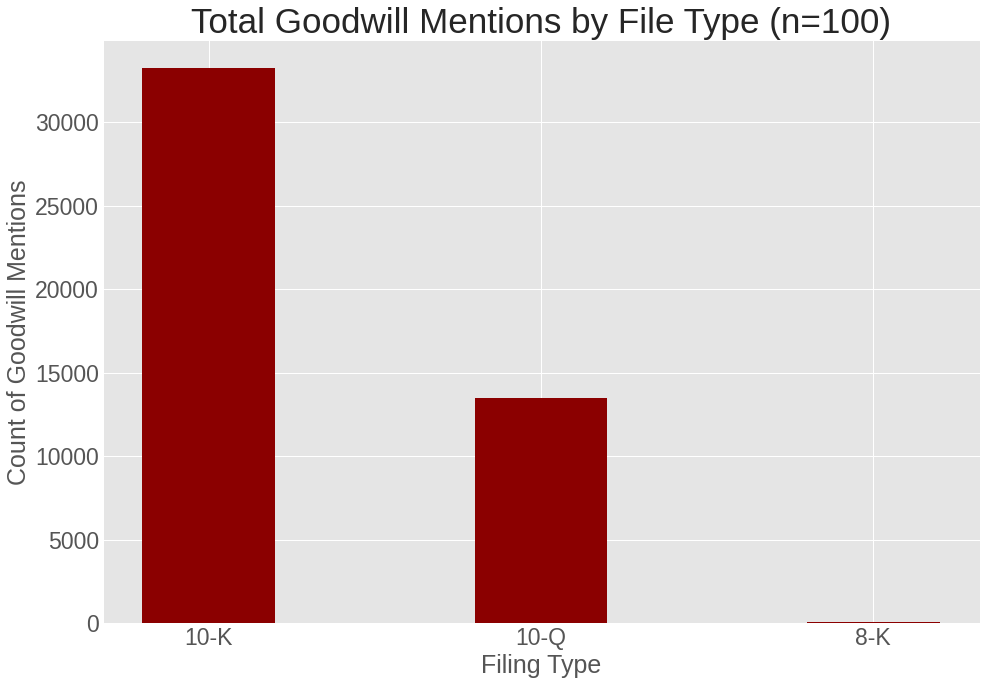

In [ ]:
'''
SUMMARY
 1. Select aggregate values from each of the sample dataframes (10-K, 10-Q, and 8K). Convert to floats.
 2. Create a dictionary with the data to be plotted.
 3. Plot the data.
'''
#create variables (floats) holding the aggregate sum of gw_count for each sample
agg_sum_gw_10K = float(sample_10K["gw_count"].aggregate(["sum"]))
agg_sum_gw_10Q = float(sample_10Q["gw_count"].aggregate(["sum"]))
agg_sum_gw_8K = float(sample_8K["gw_count"].aggregate(["sum"]))

#create a dictionary with the filing types (strings) as keys, and the variables for gw_count sums as values
plot_dict = {'10-K':agg_sum_gw_10K,'10-Q':agg_sum_gw_10Q,'8-K':agg_sum_gw_8K}

#select the keys and values from the dictionary and assign to variables (lists)
file_types = list(plot_dict.keys())
gw_count_sums = list(plot_dict.values())

#define the matplot lib plot size
plt.figure(figsize=(14,10))

#plot a bar graph with our defined x and y values 
plt.bar(file_types, gw_count_sums,color="darkred", width=0.4)

#increase the default size of x and y ticks
plt.xticks(size=23)
plt.yticks(size=23)

#create x and y labels, increasing the size
plt.xlabel("Filing Type", size=25)
plt.ylabel("Count of Goodwill Mentions", size=25)

#create a title for the plot
plt.title("Total Goodwill Mentions by File Type (n=100)", size = 35)

#use the ggplot styling
plt.style.use('ggplot')

#only display the plot
plt.show()

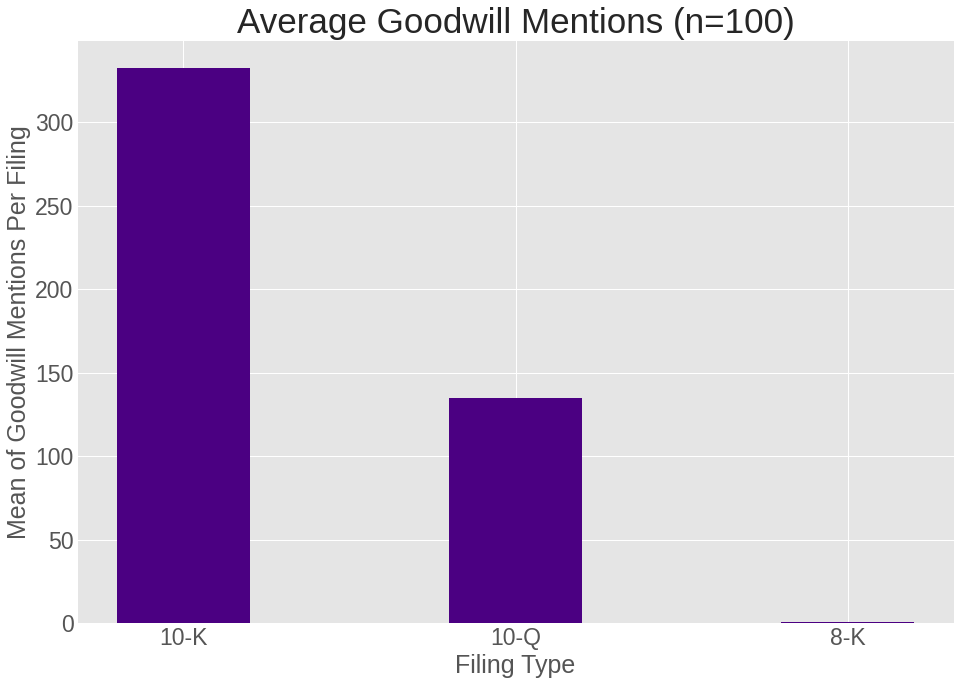

In [ ]:
'''
SUMMARY
 1. Select aggregate values from each of the sample dataframes (10-K, 10-Q, and 8K). Convert to floats.
 2. Create a dictionary with the data to be plotted.
 3. Plot the data.
'''
#create variables (floats) holding the mean of gw_count for each sample
mean_gw_10K = float(sample_10K["gw_count"].aggregate(["mean"]))
mean_gw_10Q = float(sample_10Q["gw_count"].aggregate(["mean"]))
mean_gw_8K = float(sample_8K["gw_count"].aggregate(["mean"]))

#create a dictionary with the filing types (strings) as keys, and the variables for gw_count means as values
mean_plot_dict = {'10-K':mean_gw_10K,'10-Q':mean_gw_10Q,'8-K':mean_gw_8K}

#select the keys and values from the dictionary and assign to variables (lists)
file_types = list(mean_plot_dict.keys())
gw_means = list(mean_plot_dict.values())

#define the matplot lib plot size
plt.figure(figsize=(14,10))
#plot a bar graph with our defined x and y values 
plt.bar(file_types,gw_means,color="indigo",width=0.4)

#increase the default size of x and y ticks
plt.xticks(size=23)
plt.yticks(size=23)

#create x and y labels, increasing the size
plt.xlabel("Filing Type", size=25)
plt.ylabel("Mean of Goodwill Mentions Per Filing", size=25)

#create a title for the plot
plt.title("Average Goodwill Mentions (n=100)", size = 35)

#use the ggplot styling
plt.style.use('ggplot')

#only display the plot
plt.show()

#Question 2: How often is goodwill mentioned alongside impairment?

##Section I: Create a copy dataframe with only relevant filings, then sample from it. 

In [ ]:
'''
SUMMARY: 
  1. Create a copy dataframe with only the 10-K and 10-Q filings
  2. Apply the context_search function
  3. Create two columns in the new df (gw_count & gw_context) and populate them
'''

#first set all the constant variables that we will pass to our context search function for each filing
#note that 'url' is not instantiated now because the url will change for each filing on "File Name"
search_phrase = "goodwill"
context_distance = 500

#create a copy of the  df with only 10-K and 10-Q filings
only_10K_10Q_copy = sp500_fs_data.loc[(sp500_fs_data['Form Type'] == "10-K") | (sp500_fs_data['Form Type'] == "10-Q"),:].copy().reset_index(drop=True)

#draw a large random sample of filings from the new dataframe
gwsample = only_10K_10Q_copy.sample(500).reset_index(drop = True)

#loop over items in the DF and apply the function to each URL
for row in range(len(gwsample)):
    gwsample.loc[row,"gw_context"] = context_search(gwsample.loc[row,'File Name'], "goodwill", 500)
   
    if type(gwsample.loc[row,"gw_context"]) == list:
        gwsample.loc[row,"gw_count"] = len(gwsample.loc[row,"gw_context"])
    else:
        gwsample.loc[row,"gw_count"] = 0

# Save the merged DataFrame created above to disk as a csv file. 
only_10K_10Q_copy.to_csv("goodwill_10K_10Q_df")

In [ ]:
gwsample.head(10)

,company name,cik,Company Name,Form Type,CIK,Date Filed,File Name,YR,QTR,gw_context,gw_count,context_count
0,FOSSIL GROUP INC,883569,"Fossil Group, Inc.",10-K,883569,2017-03-01,https://www.sec.gov/Archives/edgar/data/883569...,2017,1,"[><table cellpadding=""0"" cellspacing=""0"" style...",663.0,105.0
1,PROGRESS ENERGY INC,1094093,PROGRESS ENERGY INC,10-Q,1094093,2014-05-09,https://www.sec.gov/Archives/edgar/data/109409...,2014,2,"[n </td>\n <td valign=bottom width=5% style=""...",589.0,196.0
2,ESSEX PROPERTY TRUST,920522,ESSEX PROPERTY TRUST INC,10-Q,920522,2015-05-11,https://www.sec.gov/Archives/edgar/data/920522...,2015,2,NaN,0.0,0.0
3,BAKER HUGHES CO,1701605,Baker Hughes a GE Co,10-Q,1701605,2017-07-28,https://www.sec.gov/Archives/edgar/data/170160...,2017,3,NaN,0.0,0.0
4,DANA INC,26780,DANA CORP,10-Q,26780,2006-11-09,https://www.sec.gov/Archives/edgar/data/26780/...,2006,4,[>&nbsp;</td>\n <td>&nbsp;</td>\n <td al...,33.0,27.0
5,CONSTELLATION ENERGY GRP INC,1004440,CONSTELLATION ENERGY GROUP INC,10-K,1004440,2009-02-27,https://www.sec.gov/Archives/edgar/data/100444...,2009,1,[ below book value is other than temporary. if...,52.0,45.0
6,WALMART INC,104169,WAL MART STORES INC,10-Q,104169,2004-06-04,https://www.sec.gov/Archives/edgar/data/104169...,2004,2,"[2"">&nbsp;</font></td>\n<td valign=""bottom""><f...",7.0,0.0
7,CONSTELLATION BRANDS,16918,"CONSTELLATION BRANDS, INC.",10-Q,16918,2009-01-09,https://www.sec.gov/Archives/edgar/data/16918/...,2009,1,"[ <td align=""right"">3,199.0</td>\n <td>&nb...",15.0,0.0
8,FORD MOTOR CO,37996,FORD MOTOR CO,10-Q,37996,2005-05-10,https://www.sec.gov/Archives/edgar/data/37996/...,2005,2,[rent assets.....................................,17.0,11.0
9,LOCKHEED MARTIN CORP,936468,LOCKHEED MARTIN CORP,10-Q,936468,2015-07-22,https://www.sec.gov/Archives/edgar/data/936468...,2015,3,"[m"" >&nbsp;</td>\n<td valign=""bottom""><b>&nbsp...",40.0,14.0


##Section II: Search for mentions of "impairment" in the context around "goodwill"

In [ ]:
'''
SUMMARY:
 * Create a column to the gwsample dataframe for context count
 * Search through all context gathered by the context_search function in the sample
 * When our key term (impairment) appears, increment context_count by 1.
'''
#set our context_term we are searching for
context_term = "impairment"

#loop through every row in the gwsample dataframe
for row in range(len(gwsample)):
    #create a variable to store the count, setting to zero to start
    context_count = 0
    #only search those rows with at least 1 occurance of goodwill
    if gwsample.loc[row,"gw_count"] > 0:
        #now loop through each item in the context list for each row
        for context in range(len(gwsample.loc[row,"gw_context"])):
            #if our key term (impairment) is in the string, increase the context count         
            if context_term in gwsample.loc[row,"gw_context"][context]:
                context_count += 1
    gwsample.loc[row,'context_count'] = context_count

In [ ]:
#create a new dataframe with only rows in gwsample with have at least one mention of goodwill
gw_viz_pop = gwsample.loc[gwsample["gw_count"]>0,:].copy()
#from the narrowed population, sample 200
gw_viz_samp = gw_viz_pop.sample(200).reset_index(drop = True)

,company name,cik,Company Name,Form Type,CIK,Date Filed,File Name,YR,QTR,gw_context,gw_count,context_count
0,FOSSIL GROUP INC,883569,"Fossil Group, Inc.",10-K,883569,2017-03-01,https://www.sec.gov/Archives/edgar/data/883569...,2017,1,"[><table cellpadding=""0"" cellspacing=""0"" style...",663.0,105.0
1,PROGRESS ENERGY INC,1094093,PROGRESS ENERGY INC,10-Q,1094093,2014-05-09,https://www.sec.gov/Archives/edgar/data/109409...,2014,2,"[n </td>\n <td valign=bottom width=5% style=""...",589.0,196.0
2,ESSEX PROPERTY TRUST,920522,ESSEX PROPERTY TRUST INC,10-Q,920522,2015-05-11,https://www.sec.gov/Archives/edgar/data/920522...,2015,2,NaN,0.0,0.0
3,BAKER HUGHES CO,1701605,Baker Hughes a GE Co,10-Q,1701605,2017-07-28,https://www.sec.gov/Archives/edgar/data/170160...,2017,3,NaN,0.0,0.0
4,DANA INC,26780,DANA CORP,10-Q,26780,2006-11-09,https://www.sec.gov/Archives/edgar/data/26780/...,2006,4,[>&nbsp;</td>\n <td>&nbsp;</td>\n <td al...,33.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
495,GENERAL MILLS INC,40704,GENERAL MILLS INC,10-Q,40704,2013-03-20,https://www.sec.gov/Archives/edgar/data/40704/...,2013,1,"[;</b></font></td>\n<td valign=""bottom""><font ...",604.0,40.0
496,LORILLARD INC,1424847,"LORILLARD, INC.",10-Q,1424847,2015-04-21,https://www.sec.gov/Archives/edgar/data/142484...,2015,2,"[sp;</font></td>\n<td valign=""bottom""><font si...",531.0,84.0
497,BROADVISION INC,920448,BROADVISION INC,10-K,920448,2014-03-14,https://www.sec.gov/Archives/edgar/data/920448...,2014,1,"[ onclick=""top.show.togglenext( this );"">- def...",1.0,0.0
498,BERKSHIRE HATHAWAY,1067983,BERKSHIRE HATHAWAY INC,10-Q,1067983,2013-11-01,https://www.sec.gov/Archives/edgar/data/106798...,2013,4,"[d>\n<td valign=""bottom"">&nbsp;</td>\n<td vali...",381.0,14.0


##Section III: Visualization

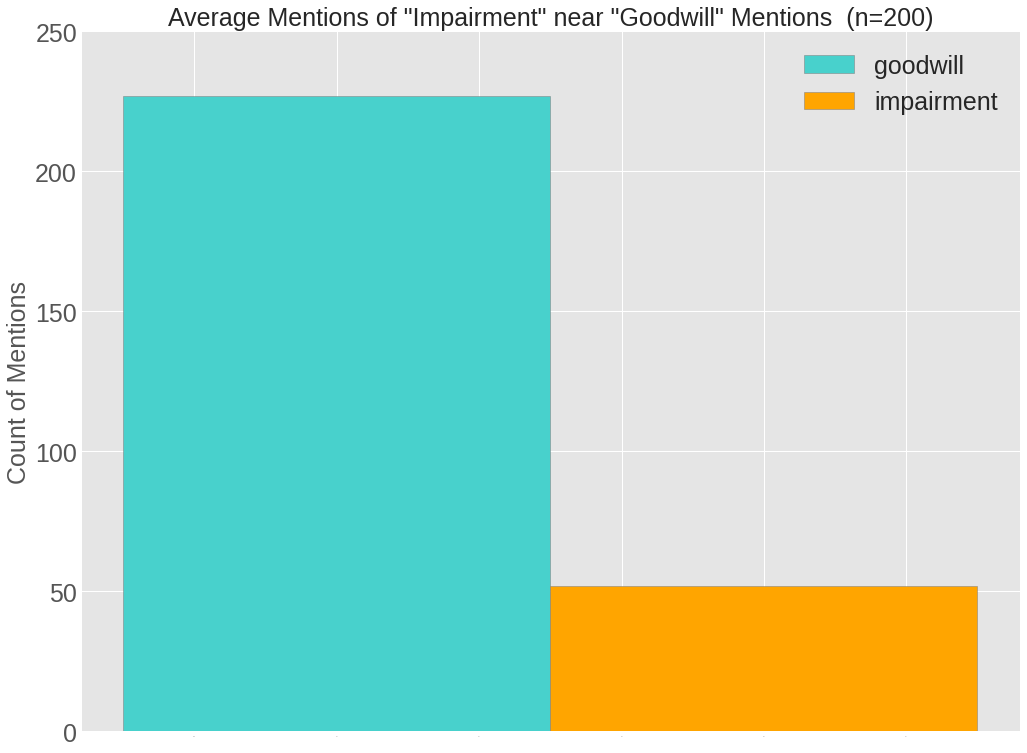

In [ ]:
'''
SUMMARY
 1. Select aggregate values from the visualization sample. Convert to floats.
 2. Plot the data in a double bar plot
 3. Beautify.
'''

#set the width of the bars
bar_width = 0.15
plt.subplots(figsize=(15,12))

#set the heights of the bars
bar_gw_count = [float(gw_viz_samp["gw_count"].aggregate(["mean"]))]
bar_context_count = [float(gw_viz_samp["context_count"].aggregate(["mean"]))]

#set the positioning of the bar on the x axis
br1 = np.arange(len(bar_gw_count))
br2 = [x + bar_width for x in br1]

#plot both bars
plt.bar(br1, bar_gw_count, color ='mediumturquoise', width = bar_width,
        edgecolor ='grey', label ='goodwill')
plt.bar(br2, bar_context_count, color ='orange', width = bar_width,
        edgecolor ='grey', label ='impairment')

#set x and y labels
plt.ylabel('Count of Mentions', fontsize = 25)

#create a title for the plot
plt.title('Average Mentions of "Impairment" near "Goodwill" Mentions  (n=200)', size = 25)

#increase the default size of x and y ticks
plt.yticks(size=25)
plt.xticks(size=0)

#limit y range to make it cleaner
plt.ylim(0,250)

#add the legend, and increase from default size
plt.legend(prop={'size': 25})

#use the ggplot styling
plt.style.use('ggplot')

#only display the plot
plt.show()